In [11]:
import os
import sys

import openpyxl
import random
random.seed(42)

import matplotlib.pyplot as plt
sys.path.append(os.path.abspath("../../util"))
from data_utils import *
from plot_utils import *

In [12]:
filename = "../../data/BicyclesRelocationData.xlsx"
wb = openpyxl.load_workbook(filename, data_only=True)

cat_sheet = wb["Categories"]
categories = [cell.value for cell in next(cat_sheet.iter_rows(min_row=1, max_row=1))]
row_surplus = next(cat_sheet.iter_rows(min_row=2, max_row=2))

s = {cat: int(row_surplus[i].value) for i, cat in enumerate(categories)}

destinations = []
p = {}
for sheet_name in wb.sheetnames:
    if sheet_name.startswith("ExpectedProfitsArea"):
        ws = wb[sheet_name]
        dest_num = sheet_name[len("ExpectedProfitsArea"):]
        area = "Area" + dest_num
        if area not in destinations:
            destinations.append(area)
        header = [cell.value for cell in next(ws.iter_rows(min_row=1, max_row=1))]
        rows = list(ws.iter_rows(min_row=2, values_only=True))
        for i, cat in enumerate(header):
            profits = [row[i] for row in rows if row[i] is not None]
            p[(cat, area)] = profits

In [ ]:
gene_order  = [(i, j) for i in categories for j in destinations]
gene_bounds = {(i, j): (0, s[i]) for (i, j) in gene_order}

def compute_total_profit(i, j, allocation):
    """
    Add the first N values ​​of the list of expected profits.
    """
    profits = p.get((i, j), [])
    return sum(profits[:allocation]) if allocation > 0 else 0

def evaluate(individual):
    """
    Evaluates the solution and applies penalties for invalid allocations.
    """
    sol = {key: individual[idx] for idx, key in enumerate(gene_order)}

    profit = sum(compute_total_profit(i, j, sol[(i, j)]) for (i, j) in gene_order)

    penalty = 0
    for i in categories:
        total_alloc = sum(sol[(i, j)] for j in destinations)
        if total_alloc > s[i]:
            penalty += (total_alloc - s[i]) * 1000  

    return profit - penalty

def create_initial_solution():
    return [random.randint(lb, ub) for (lb, ub) in gene_bounds.values()]

In [13]:
def neighborhood1(solution):
    
    neighbor = solution.copy()
    idx = random.randrange(len(solution))
    lb, ub = list(gene_bounds.values())[idx]
    delta = random.choice([-1, 1])
    new_val = max(lb, min(ub, neighbor[idx] + delta))
    neighbor[idx] = new_val
    
    return neighbor

In [22]:
def tabu_search(max_iter=10000, tabu_tenure=3, neighborhood_size=500):
    
    current_solution = create_initial_solution()
    current_fitness = evaluate(current_solution)
    best_solution = current_solution[:]
    best_fitness = current_fitness

    tabu_list = []
    fitness_history = [best_fitness]

    for iter in range(max_iter):
        neighborhood = [neighborhood1(current_solution) for _ in range(neighborhood_size)]
        candidate_fitnesses = [evaluate(candidate) for candidate in neighborhood]

        best_candidate = None
        best_candidate_fitness = float('-inf')

        for candidate, cand_fit in zip(neighborhood, candidate_fitnesses):
            candidate_tuple = tuple(candidate)
            if candidate_tuple in tabu_list and cand_fit <= best_fitness:
                continue 
            if cand_fit > best_candidate_fitness:
                best_candidate = candidate
                best_candidate_fitness = cand_fit

        if best_candidate is None:
            break
        
        current_solution = best_candidate
        current_fitness = best_candidate_fitness

        tabu_list.append(tuple(current_solution))
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)

        if current_fitness > best_fitness:
            best_solution = current_solution[:]
            best_fitness = current_fitness

        fitness_history.append(best_fitness)
        print(f"Iteração {iter}: Melhor Lucro = {best_fitness}")

    return best_solution, best_fitness, fitness_history

In [23]:
%%time

best_sol, best_fit, fitness_history = tabu_search()

Iteração 0: Melhor Lucro = -4486616.9407
Iteração 1: Melhor Lucro = -4485616.9407
Iteração 2: Melhor Lucro = -4484616.9407
Iteração 3: Melhor Lucro = -4483616.9407
Iteração 4: Melhor Lucro = -4482616.9407
Iteração 5: Melhor Lucro = -4481616.9407
Iteração 6: Melhor Lucro = -4480616.9407
Iteração 7: Melhor Lucro = -4479616.9407
Iteração 8: Melhor Lucro = -4478616.9407
Iteração 9: Melhor Lucro = -4477616.9407
Iteração 10: Melhor Lucro = -4476616.9407
Iteração 11: Melhor Lucro = -4475616.9407
Iteração 12: Melhor Lucro = -4474616.9407
Iteração 13: Melhor Lucro = -4473616.9407
Iteração 14: Melhor Lucro = -4472616.9407
Iteração 15: Melhor Lucro = -4471616.9407
Iteração 16: Melhor Lucro = -4470616.9407
Iteração 17: Melhor Lucro = -4469616.9407
Iteração 18: Melhor Lucro = -4468616.9407
Iteração 19: Melhor Lucro = -4467616.9407
Iteração 20: Melhor Lucro = -4466616.9407
Iteração 21: Melhor Lucro = -4465616.9407
Iteração 22: Melhor Lucro = -4464616.9407
Iteração 23: Melhor Lucro = -4463616.9407
It

In [24]:
solution_dict = {key: best_sol[idx] for idx, key in enumerate(gene_order)}

print(f"Best solution (allocations by (Category, Destination)):")
for key, value in solution_dict.items():
    print(f"{key}: {value}")

print(f"Best solution raw fitness (profit minus penalty): {best_fit}")

Best solution (allocations by (Category, Destination)):
('Child', 'Area1'): 0
('Child', 'Area2'): 0
('Child', 'Area3'): 91
('Child', 'Area4'): 103
('Child', 'Area5'): 0
('Child', 'Area6'): 78
('Child', 'Area7'): 0
('Adult', 'Area1'): 0
('Adult', 'Area2'): 0
('Adult', 'Area3'): 91
('Adult', 'Area4'): 97
('Adult', 'Area5'): 0
('Adult', 'Area6'): 82
('Adult', 'Area7'): 0
('Electric', 'Area1'): 14
('Electric', 'Area2'): 0
('Electric', 'Area3'): 91
('Electric', 'Area4'): 77
('Electric', 'Area5'): 0
('Electric', 'Area6'): 97
('Electric', 'Area7'): 0
('Racing', 'Area1'): 0
('Racing', 'Area2'): 0
('Racing', 'Area3'): 93
('Racing', 'Area4'): 103
('Racing', 'Area5'): 0
('Racing', 'Area6'): 71
('Racing', 'Area7'): 0
('Mountain', 'Area1'): 0
('Mountain', 'Area2'): 0
('Mountain', 'Area3'): 100
('Mountain', 'Area4'): 103
('Mountain', 'Area5'): 0
('Mountain', 'Area6'): 79
('Mountain', 'Area7'): 0
('Tricycle', 'Area1'): 10
('Tricycle', 'Area2'): 0
('Tricycle', 'Area3'): 106
('Tricycle', 'Area4'): 95
(

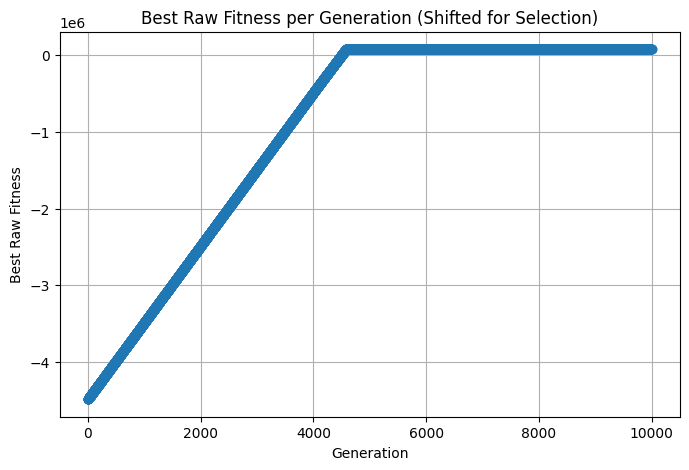

In [25]:
plot_fitness_history(fitness_history)